## Import Tools

In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io
import random
import math
import matplotlib.pyplot as plt
import torch.nn.functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

## Dataset Processing

### Read in the original dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset = '/content/drive/MyDrive/Project 1/Dataset/'
train_dl_origin = torch.load(dataset+'train_dl.pt')
valid_dl_origin = torch.load(dataset+'valid_dl.pt')

train_CSI = train_dl_origin.dataset[:][0]
train_label = train_dl_origin.dataset[:][1][:,0:2]

valid_CSI = valid_dl_origin.dataset[:][0]
valid_label = valid_dl_origin.dataset[:][1][:,0:2]

### CSI Processing: Take Modulus of complex matrices

In [4]:
train_CSI_modulus = torch.abs(train_CSI)
valid_CSI_modulus = torch.abs(valid_CSI)

In [5]:
print(train_CSI_modulus.shape)
print(valid_CSI_modulus.shape)
print(train_label.shape)

torch.Size([15000, 1, 4, 1632])
torch.Size([5000, 1, 4, 1632])
torch.Size([15000, 2])


###  CSI Processing: Normalize to [0,1]

In [6]:
from torchvision import transforms

# You would typically calculate these values from the training set
mean = train_CSI_modulus.mean()
std = train_CSI_modulus.std()

# Then create a transform to normalize the data
normalize = transforms.Normalize(mean.tolist(), std.tolist())

# Apply the transform to your data
# Note: You need to make sure your data is in the form of a tensor before you can apply the transform
train_CSI_modulus_normalized = normalize(train_CSI_modulus)
valid_CSI_modulus_normalized = normalize(valid_CSI_modulus)

print(train_CSI_modulus_normalized.shape)
print(valid_CSI_modulus_normalized.shape)

torch.Size([15000, 1, 4, 1632])
torch.Size([5000, 1, 4, 1632])


KNN Classifier

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming train_CSI_modulus_normalized and valid_CSI_modulus_normalized are your input features
# Reshape the data to 2D array (samples, features) for scikit-learn
train_data_flat = train_CSI_modulus_normalized.reshape(train_CSI_modulus_normalized.shape[0], -1)
valid_data_flat = valid_CSI_modulus_normalized.reshape(valid_CSI_modulus_normalized.shape[0], -1)

# Ensure the data is in numpy format (if they are not already in that format)
train_data_flat_np = np.array(train_data_flat)
valid_data_flat_np = np.array(valid_data_flat)

# No need to flatten the labels since we are doing regression
train_labels_np = np.array(train_label)
valid_labels_np = np.array(valid_label)

# Initialize the KNeighborsRegressor
# You can change the number of neighbors and other parameters as needed
knn = KNeighborsRegressor(n_neighbors=3)

# Fit the model on the training data
knn.fit(train_data_flat_np, train_labels_np)

# Predict the positions on validation dataset
predictions = knn.predict(valid_data_flat_np)

# Evaluate the model using a regression metric instead of accuracy
# Mean Squared Error (MSE) is a common metric for regression.
mse = mean_squared_error(valid_labels_np, predictions)


Validation MSE: 0.1574225127696991


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute various regression metrics
mse = mean_squared_error(valid_labels_np, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(valid_labels_np, predictions)
r2 = r2_score(valid_labels_np, predictions)

print(f'Validation MSE: {mse}')
print(f'Validation RMSE: {rmse}')
print(f'Validation MAE: {mae}')
print(f'Validation R-squared: {r2}')

Validation MSE: 0.1574225127696991
Validation RMSE: 0.3967650532722473
Validation MAE: 0.013039417564868927
Validation R-squared: 0.9986344028537879


ANN Model

In [11]:
!pip install tensorflow


Epoch 1/100
422/422 [==============================] - 8s 12ms/step - loss: 47.2460 - val_loss: 31.7594
Epoch 2/100
422/422 [==============================] - 5s 11ms/step - loss: 26.5378 - val_loss: 19.7996
Epoch 3/100
422/422 [==============================] - 3s 8ms/step - loss: 18.7742 - val_loss: 14.0404
Epoch 4/100
422/422 [==============================] - 3s 8ms/step - loss: 14.2944 - val_loss: 14.9076
Epoch 5/100
422/422 [==============================] - 4s 9ms/step - loss: 12.8383 - val_loss: 13.2488
Epoch 6/100
422/422 [==============================] - 4s 10ms/step - loss: 10.3638 - val_loss: 9.2720
Epoch 7/100
422/422 [==============================] - 3s 8ms/step - loss: 10.1679 - val_loss: 11.7705
Epoch 8/100
422/422 [==============================] - 3s 8ms/step - loss: 9.1101 - val_loss: 7.3323
Epoch 9/100
422/422 [==============================] - 4s 9ms/step - loss: 7.5845 - val_loss: 10.7372
Epoch 10/100
422/422 [==============================] - 4s 10ms/step - los

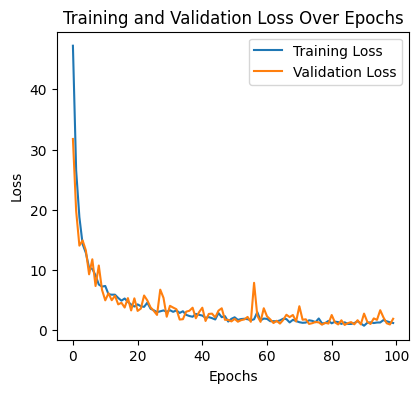

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have your training and validation data ready as `train_data_flat_np` and `valid_data_flat_np`
# And the labels as `train_labels_np` and `valid_labels_np`

# Define the model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(train_data_flat_np.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(2)  # Output layer with 2 neurons for the x and y coordinates
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
history = model.fit(train_data_flat_np, train_labels_np, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Predict the positions on validation dataset
predictions = model.predict(valid_data_flat_np)

# Compute various regression metrics
mse = mean_squared_error(valid_labels_np, predictions)
r2 = r2_score(valid_labels_np, predictions)

print(f'Validation MSE: {mse}')
print(f'Validation R-squared: {r2}')

# If you wish to monitor the training process for overfitting or underfitting,
# you can plot the training loss and the validation loss over epochs.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
